In [1]:
import pandas as pd
from pointpats.geometry import(TREE_TYPES)
from scipy import spatial
import libpysal as ps
import numpy as np
from pointpats import PointPattern
from pointpats import PoissonPointProcess, PoissonClusterPointProcess, Window, poly_from_bbox, PointPattern
import libpysal as ps
from libpysal.cg import shapely_ext
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pointpats.quadrat_statistics as qs
from pointpats import PointPattern, as_window
from pointpats import PoissonPointProcess as csr
import pandas as pd
import geopandas
import pysal
import seaborn
import contextily
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import geopandas as gpd
from shapely.geometry import Point, Polygon
import glob
import os
import re

/Users/gocchini/opt/anaconda3/envs/paper_3/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
<string>:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.ht

# Working on intangibles :)

In [2]:
data = pd.read_pickle('/Users/gocchini/Desktop/paper_3/data/complete_df_paper_3.pkl')

## Delete firms for which the postcode is different from the postcode found in its website text

In [3]:
#remember this damn tilde in pandas!! 
data = data[~(data['suspicious'] == 'SUSPICIOUS!')]

## Assign coordinates to firms based on postcode centroids, coordinates are taken from London coordinates

In [4]:
all_postcodes_centroids= pd.read_csv('/Users/gocchini/Downloads/NSPL_NOV_2022_UK/Data/NSPL_NOV_2022_UK.csv')
all_postcodes_centroids = all_postcodes_centroids[['pcd', 'lat', 'long']]

/var/folders/0f/pzhfvnbj63jg3sk3nj099q3w0000gq/T/ipykernel_19490/3818275856.py:1: DtypeWarning: Columns (31,36) have mixed types. Specify dtype option on import or set low_memory=False.
  all_postcodes_centroids= pd.read_csv('/Users/gocchini/Downloads/NSPL_NOV_2022_UK/Data/NSPL_NOV_2022_UK.csv')


In [5]:
data_with_coords = data.merge(all_postcodes_centroids, left_on = 'R/O Full Postcode.1_x', right_on = 'pcd', how = 'left')

## Delete suspicioius postcodes (postcdes with >10 firms)

In [7]:
postcodes_instances = data_with_coords['R/O Full Postcode.1_x'].value_counts()
big_postcodes_instances = pd.DataFrame(postcodes_instances)
big_postcodes_instances = big_postcodes_instances.loc[big_postcodes_instances['R/O Full Postcode.1_x'] >=10]
big_postcodes_instances = big_postcodes_instances.index.tolist()

def delete_sus(df, big_postcode):
    if df['R/O Full Postcode.1_x'] == big_postcode:
        df['too_big'] == True
    return df 

#this is exactly the same as isint :) 

def delete_sus(df, postcodes):
    for x in postcodes:
        df.drop(df.index[df['R/O Full Postcode.1_x'] == x], inplace = True)
    return df 

In [8]:
data_non_sus = data_with_coords[~data_with_coords['R/O Full Postcode.1_x'].isin(big_postcodes_instances)]

In [10]:
data_non_sus.to_pickle('/Users/gocchini/Desktop/paper_3/data/data_non_sus_10.pkl')

## Start preparing data for KDE plotting and Kinhom estimation

In [11]:
coords = data_non_sus[['lat', 'long']]
pts = coords.apply(lambda r: Point(r.long, r.lat), axis=1)
gdb = gpd.GeoDataFrame(coords.assign(geometry=pts), \
                       crs={'init' :'epsg:4326'})
gdb = gdb.to_crs(epsg=27700)
xys = gdb['geometry'].apply(lambda pt: pd.Series({'x': pt.x, 'y': pt.y}))
gdb['x'] = xys['x']
gdb['y'] = xys['y']

/Users/gocchini/opt/anaconda3/envs/paper_3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## Define London boundaries for plotting

In [12]:
london = geopandas.read_file('/Users/gocchini/Desktop/paper_3/data/shapefiles/statistical-gis-boundaries-london/ESRI/MSOA_2004_London_High_Resolution.shp')
#look at it based on LA
london = london.dissolve(by = 'LA_NAME')
london.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

/var/folders/0f/pzhfvnbj63jg3sk3nj099q3w0000gq/T/ipykernel_19490/2425647863.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(gdb, x = 'x', y = 'y', ax=ax,


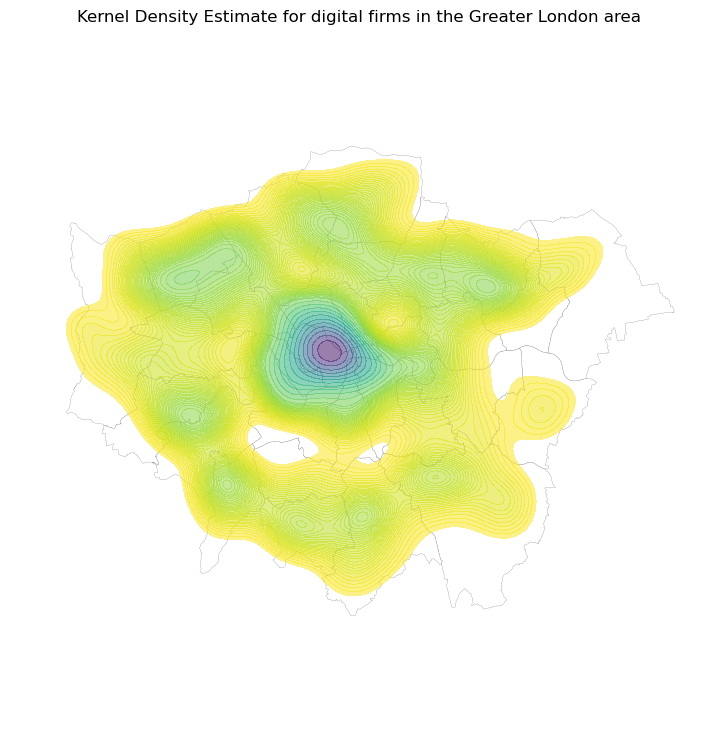

In [13]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(9, 9))
# Add a base layer with the LSOA geography
london.plot(ax = ax, color='white', edgecolor='black', linewidth=0.1)
# Generate KDE
seaborn.kdeplot(gdb, x = 'x', y = 'y', ax=ax, 
    n_levels=50,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Remove axes
ax.set_axis_off()
# Add title
ax.set_title("Kernel Density Estimate for digital firms in the Greater London area")
# Keep axes proportionate
plt.axis('equal')
# Draw map
plt.show()

# Let's do the same for tangibles! :) 
## These data are not checked for suspiciousness though!!! Gotta do that?

In [14]:
tangibles_main_shareholder = pd.concat([pd.read_excel(f, 'Results') for f in glob.glob('/Users/gocchini/Desktop/paper_3/data/FAME_TANGIBLES/*.xlsx')], ignore_index = True)

# Check if main shareholder is natural or legal entity...had already done it in prevous notebook for digitals 

In [15]:
with open ('/Users/gocchini/Desktop/paper_3/data/list-of-salutations-titles-honorifics.txt') as f: 
    lines = f.readlines()
honorifics = [line.strip() for line in lines]

In [20]:
def natural_entity_finder(entity, honorifics):
    if type(entity) != float:
        if any(honorific in entity for honorific in honorifics): 
            return 'natural person'
        else:
            return 'conglomerate'

tangibles_main_shareholder['natural_entity_finder'] = tangibles_main_shareholder.apply(lambda x: natural_entity_finder(x['PSC - Name'], honorifics), axis = 1)
tangibles_main_shareholder = tangibles_main_shareholder.loc[tangibles_main_shareholder['natural_entity_finder'] ==  'natural person']
tangibles_main_shareholder = tangibles_main_shareholder.loc[tangibles_main_shareholder['R/O Full Postcode'].notna()]

## Delete suspicioius postcodes (postcdes with >10 firms)

In [21]:
# deleting sus postcodes 
postcodes_instances_tan = tangibles_main_shareholder['R/O Full Postcode'].value_counts()
big_postcodes_instances_tan = pd.DataFrame(postcodes_instances_tan)
big_postcodes_instances_tan = big_postcodes_instances_tan.loc[big_postcodes_instances_tan['R/O Full Postcode'] >=10]
big_postcodes_instances_tan = big_postcodes_instances_tan.index.tolist()
tan_non_sus = tangibles_main_shareholder[~tangibles_main_shareholder['R/O Full Postcode'].isin(big_postcodes_instances_tan)]

## make sure firms are actually in London

In [22]:
london_postcodes = pd.read_csv('/Users/gocchini/Desktop/paper_3/data/london_postcodes-ons-postcodes-directory-feb22.csv')

In [23]:
london_postcodes = london_postcodes['pcd'].tolist()
tan_non_sus_london =  tan_non_sus[tan_non_sus['R/O Full Postcode'].isin(london_postcodes)]

## Assign coordinates to firms based on postcode centroids, coordinates are taken from London coordinates

In [26]:
tangibles_with_coords = tan_non_sus_london.merge(all_postcodes_centroids, left_on = 'R/O Full Postcode', right_on = 'pcd', how = 'left')

In [108]:
tangibles_with_coords.to_pickle('/Users/gocchini/Desktop/paper_3/data/tang_non_sus.pkl')

In [27]:
tang_coords = tangibles_with_coords[['lat', 'long']]

In [28]:
pts = tang_coords.apply(lambda r: Point(r.long, r.lat), axis=1)

In [29]:
gdb = gpd.GeoDataFrame(tang_coords.assign(geometry=pts), \
                       crs={'init' :'epsg:4326'})
     

/Users/gocchini/opt/anaconda3/envs/paper_3/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [30]:
gdb = gdb.to_crs(epsg=27700)

In [31]:
xys = gdb['geometry'].apply(lambda pt: pd.Series({'x': pt.x, 'y': pt.y}))
gdb['x'] = xys['x']
gdb['y'] = xys['y']

/var/folders/0f/pzhfvnbj63jg3sk3nj099q3w0000gq/T/ipykernel_19490/3879092012.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  seaborn.kdeplot(gdb, x = 'x', y = 'y', ax=ax,


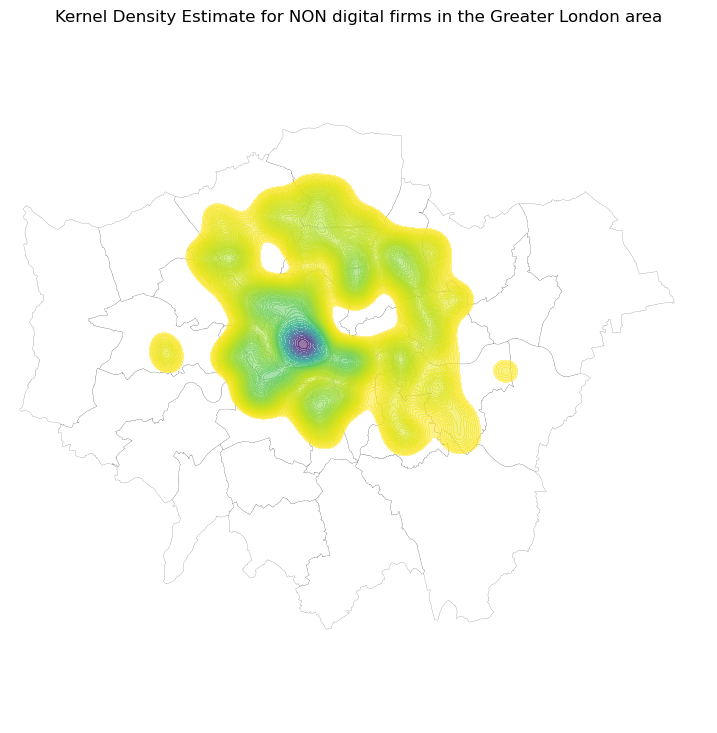

In [32]:
# Set up figure and axes
f, ax = plt.subplots(1, figsize=(9, 9))
# Add a base layer with the LSOA geography
london.plot(ax = ax, color='white', edgecolor='black', linewidth=0.1)
# Generate KDE
seaborn.kdeplot(gdb, x = 'x', y = 'y', ax=ax, 
    n_levels=100,
    shade=True,
    alpha=0.55,
    cmap="viridis_r",
)
# Remove axes
ax.set_axis_off()
# Add title
ax.set_title("Kernel Density Estimate for NON digital firms in the Greater London area")
# Keep axes proportionate
plt.axis('equal')
# Draw map
plt.show()